# Generate Explanation
In this notebook, we demonstrate how MHCXAI is used. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pickle, importlib
import argparse
import subprocess
import sys
import lime
import lime.lime_tabular
import shap
%matplotlib inline

# Prerequisites 
### For SHAP, it is recommended to reduce training data using clustering techniques such as kmeans (See https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html, data)

In [5]:
# Generate kmeans summarization of training data 
# Example for transphla training data
# Caution: If you have 9 mer, make sure you summarize only 9-mer training peptide
# Note: In the repo we didn't provide training data of the predictors which can be downloaded from respective repos

AA = ['0=A','1=R','2=N','3=D','4=C','5=E','6=Q','7=G','8=H','9=I','10=L','11=K','12=M','13=F','14=P','15=S','16=T','17=W','18=Y','19=V','20=B','21=J','22=O','23=U','24=X','25=Z']
        
def AA_to_num(peptide):
    values = dict([(x.split('=')[1], x.split('=')[0]) for x in AA])
    peptide = np.array(list(map(lambda x: values[x], peptide)))
    return peptide

def num_to_AA(peptide):
    values = dict([(int(x.split('=')[0]), x.split('=')[1]) for x in AA])
    peptide = list(map(lambda x: values[x], peptide))
    str_peptide = ''
    for aa in peptide:
        str_peptide+=aa
    return str_peptide

def transform_train(train_file):
    train = np.genfromtxt(train_file, delimiter=',', dtype='<U20')
    train = np.array([AA_to_num(peptide) for peptide in train],dtype='<U20')
    return train.astype(float)

train_file = "../transPHLA/TransPHLA-AOMP/transPHLA_train_len9.txt" # Add path to your training file
train = transform_train(train_file)
train.shape
train_summary = shap.kmeans(train, 50)

# if you need to save training data in numpy
# np.save("./data/training_kmeans/transPHLA_train_len9.npy",train)

filehandler = open('./data/training_kmeans/transPHLA_train_len9.pkl', 'wb') 
pickle.dump(train_summary, filehandler)
filehandler.close()

# USAGE for MHCflurry 

LIME binding affinity done
LIME presentation score done
SHAP binding affinity done
SHAP presentation score done


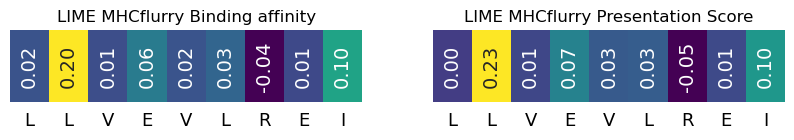

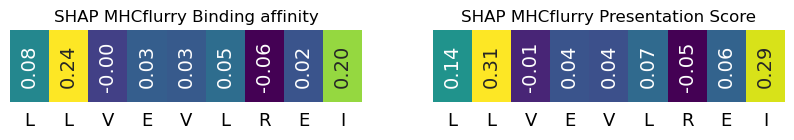

In [158]:
# LIME binding affinity
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_mhcflurry.csv",
           "--index", "0",
           "--predictor","mhcflurry",
           "--xai","LIME",
           "--mode","affinity",
           "--trainf_path","./data/training_kmeans/MHCFlurry_D6_Train_ps_len9.txt",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("LIME binding affinity done")

# LIME presentation score
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_mhcflurry.csv",
           "--index", "0",
           "--predictor","mhcflurry",
           "--xai","LIME",
           "--mode","presentation_score",
           "--trainf_path","./data/training_kmeans/MHCFlurry_D6_Train_ps_len9.txt",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("LIME presentation score done")

# SHAP binding affinity
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_mhcflurry.csv",
           "--index", "0",
           "--predictor","mhcflurry",
           "--xai","SHAP",
           "--mode","affinity",
           "--trainf_path","./data/training_kmeans/MHCFlurry_D6_Train_ps_len9.pkl",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("SHAP binding affinity done")

# SHAP presentation score
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_mhcflurry.csv",
           "--index", "0",
           "--predictor","mhcflurry",
           "--xai","SHAP",
           "--mode","presentation_score",
           "--trainf_path","./data/training_kmeans/MHCFlurry_D6_Train_ps_len9.pkl",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("SHAP presentation score done")


# Plot
#1
fig,ax = plt.subplots(1,2,figsize=(5*2,1.25*0.75))
peptide = 'LLVEVLREI'
values = np.load('./example/LIME_LLVEVLREI_HLA-A0201_mhcflurry_affinity.npy')[1:10]
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[0])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("LIME MHCflurry Binding affinity")

#2
values = np.load('./example/LIME_LLVEVLREI_HLA-A0201_mhcflurry_presentation_score.npy')[1:10]
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[1])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("LIME MHCflurry Presentation Score")

#3
fig,ax = plt.subplots(1,2,figsize=(5*2,1.25*0.75))
values = np.load('./example/SHAP_LLVEVLREI_HLA-A0201_mhcflurry_affinity.npy')
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[0])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("SHAP MHCflurry Binding affinity")

#4
values = np.load('./example/SHAP_LLVEVLREI_HLA-A0201_mhcflurry_presentation_score.npy')
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[1])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("SHAP MHCflurry Presentation Score")

plt.show()

# USAGE for netMHCpan
### Make sure to change tha path to your netMHCpan installation in MHCXAI.py

LIME binding affinity Rank done
LIME Elution Ligand Rank done
SHAP binding affinity Rank done
SHAP Elution Ligand Rank done


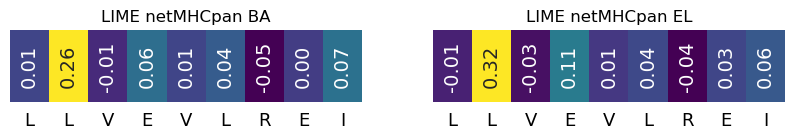

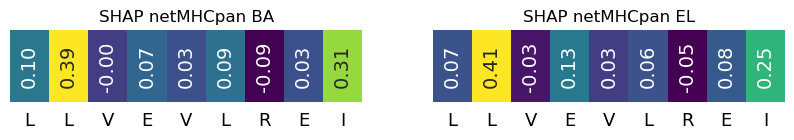

In [189]:
# LIME binding affinity
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_netmhcpan.csv",
           "--index", "0",
           "--predictor","netmhcpan",
           "--xai","LIME",
           "--mode","BA_Rank",
           "--trainf_path","./data/training_kmeans/netMHCpan_train_len9.txt",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("LIME binding affinity Rank done")

# LIME Elution Ligand
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_netmhcpan.csv",
           "--index", "0",
           "--predictor","netmhcpan",
           "--xai","LIME",
           "--mode","EL_Rank",
           "--trainf_path","./data/training_kmeans/netMHCpan_train_len9.txt",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("LIME Elution Ligand Rank done")

# SHAP binding affinity
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_netmhcpan.csv",
           "--index", "0",
           "--predictor","netmhcpan",
           "--xai","SHAP",
           "--mode","BA_Rank",
           "--trainf_path","./data/training_kmeans/netMHCpan_train_len9.pkl",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("SHAP binding affinity Rank done")

# SHAP Elution Ligand
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_netmhcpan.csv",
           "--index", "0",
           "--predictor","netmhcpan",
           "--xai","SHAP",
           "--mode","EL_Rank",
           "--trainf_path","./data/training_kmeans/netMHCpan_train_len9.pkl",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("SHAP Elution Ligand Rank done")


# Plot
#1
fig,ax = plt.subplots(1,2,figsize=(5*2,1.25*0.75))
peptide = 'LLVEVLREI'
values = np.load('./example/LIME_LLVEVLREI_HLA-A02:01_netmhcpan_BA_Rank.npy')[1:10]
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[0])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("LIME netMHCpan BA")

#2
values = np.load('./example/LIME_LLVEVLREI_HLA-A02:01_netmhcpan_EL_Rank.npy')[1:10]
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[1])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("LIME netMHCpan EL")

#3
fig,ax = plt.subplots(1,2,figsize=(5*2,1.25*0.75))
values = np.load('./example/SHAP_LLVEVLREI_HLA-A02:01_netmhcpan_BA_Rank.npy')
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[0])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("SHAP netMHCpan BA")

#4
values = np.load('./example/SHAP_LLVEVLREI_HLA-A02:01_netmhcpan_EL_Rank.npy')
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[1])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("SHAP netMHCpan EL")

plt.show()


# USAGE MHCfovea
### Make sure to add path to mhcfovea installation


LIME done
SHAP done


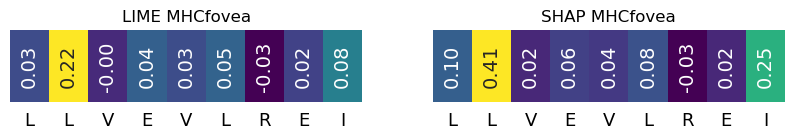

In [4]:
# LIME 
command = ["python", "./src/MHCXAI.py", 
           "--input_list", "./example/peptide_allele_mhcfovea.csv",
           "--index", "0", 
           "--predictor", "mhcfovea", 
           "--xai", "LIME",
           "--mode", "None", 
           "--trainf_path", "./data/training_kmeans/MHCFovea_train_seq.txt", 
           "--dest", "./example/"]

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("LIME done")

# SHAP
command = ["python", "./src/MHCXAI.py", 
           "--input_list", "./example/peptide_allele_mhcfovea.csv",
           "--index", "0", 
           "--predictor", "mhcfovea", 
           "--xai", "SHAP",
           "--mode", "None", 
           "--trainf_path", "./data/training_kmeans//MHCFovea_train_len9.pkl", 
           "--dest", "./example/"]

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("SHAP done")


# Plot
#1
fig,ax = plt.subplots(1,2,figsize=(5*2,1.25*0.75))
peptide = 'LLVEVLREI'
values = np.load('./example/LIME_LLVEVLREI_A*02:01_mhcfovea_None.npy')[1:10]
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[0])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("LIME MHCfovea")

#2
values = np.load('./example/SHAP_LLVEVLREI_A*02:01_mhcfovea_None.npy')
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[1])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("SHAP MHCfovea")

plt.show()


# USAGE TransPHLA
### Make sure to add path to TransPHLA installation
### Make sure to add path to seqs in line 133 in MHCXAI.py

LIME done
SHAP done


''

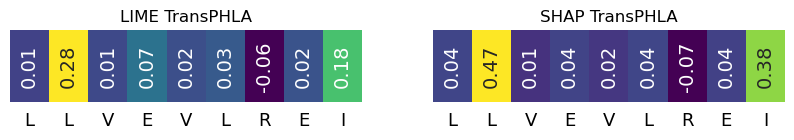

In [7]:
# LIME 
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_transphla.csv",
           "--index", "0",
           "--predictor","transphla",
           "--xai","LIME",
           "--mode","None",
           "--trainf_path","./data/training_kmeans/transPHLA_train_len9.txt",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("LIME done")

# SHAP 
command = ["python", "./src/MHCXAI.py",
           "--input_list", "./example/peptide_allele_transphla.csv",
           "--index", "0",
           "--predictor","transphla",
           "--xai","SHAP",
           "--mode","None",
           "--trainf_path","./data/training_kmeans/transPHLA_train_len9.pkl",
           "--dest",'./example/']

result = subprocess.run(command,stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
print("SHAP done")

# Plot
#1
fig,ax = plt.subplots(1,2,figsize=(5*2,1.25*0.75))
peptide = 'LLVEVLREI'
values = np.load('./example/LIME_LLVEVLREI_HLA-A*02:01_transphla_None.npy')[1:10]
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[0])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("LIME TransPHLA")

#2
values = np.load('./example/SHAP_LLVEVLREI_HLA-A*02:01_transphla_None.npy')
pos_importance_df = pd.DataFrame(values.reshape(-1, len(values)),columns = [aa_ for aa_ in peptide])
b = sns.heatmap(pos_importance_df, annot=True, fmt=".2f", cmap='viridis', 
            annot_kws={'rotation': 90,'fontsize':14}, cbar=False,ax=ax[1])

b.tick_params(left=False,bottom=False)
b.set_yticklabels('')
b.set_xticklabels(b.get_xticklabels(), size=13)
b.set_title("SHAP TransPHLA")


plt.show()

# Aggregating explanations example - SHAP for A0201

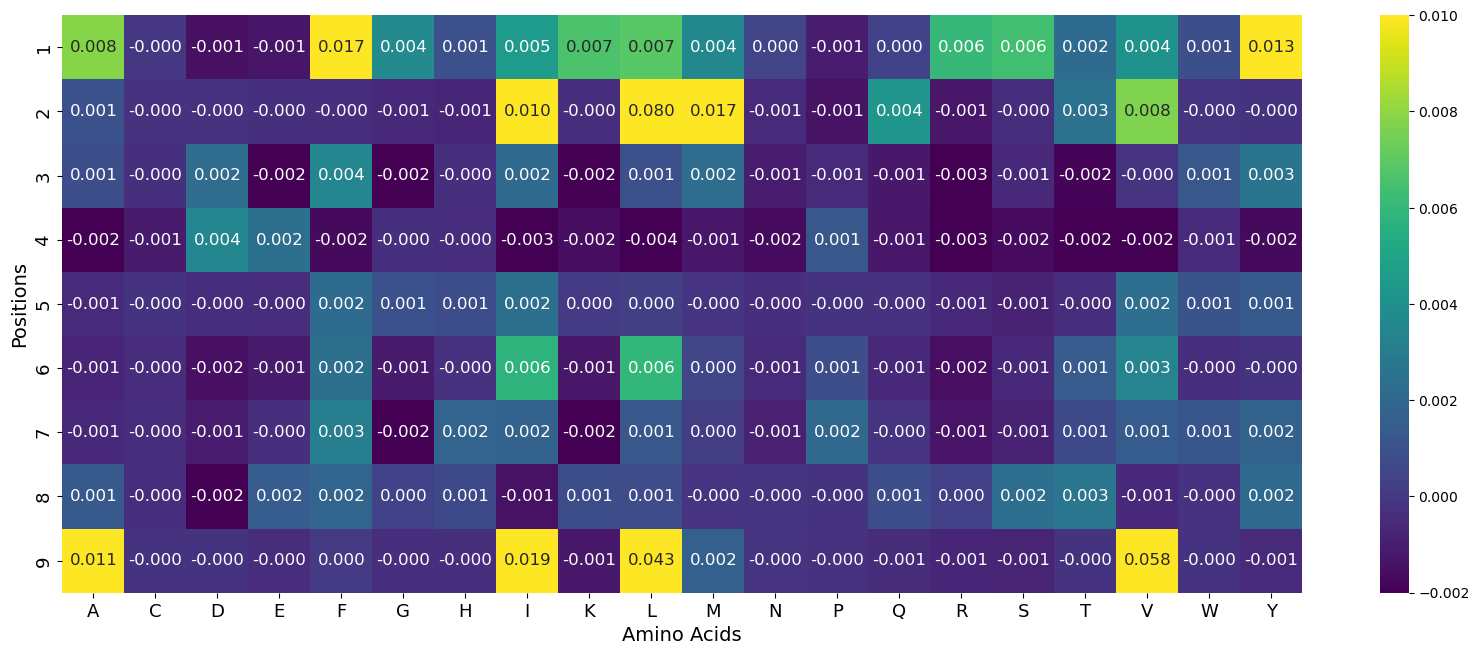

In [53]:
# A0201 SHAP aggregate
path = './example/raw_data/HLAA0201_SHAP_MHCFlurry.pkl'
fileObj = open(path, 'rb')
SHAP_A0201_df = pickle.load(fileObj)
fileObj.close()

def get_aa_pos_mat(df, xai) :
    aa = [aa_ for aa_ in 'ACDEFGHIKLMNPQRSTVWY']
    aa_pos_mat = np.zeros([len(aa),9])
    for peptide in df.index:
        if xai=='SHAP':
            values = df.loc[peptide].to_numpy()
            for idx,i in enumerate(peptide):
                x = aa.index(i)
                y = idx
                aa_pos_mat[x][y] = aa_pos_mat[x][y] + values[y]
        elif xai=='LIME':
            values = df.loc[peptide].to_numpy()[1:10]
            for idx,i in enumerate(peptide):
                x = aa.index(i)
                y = idx
                aa_pos_mat[x][y] = aa_pos_mat[x][y] + values[y]
        
    aa_pos_mat_df = pd.DataFrame(aa_pos_mat/len(df),columns = ['1','2','3','4','5','6','7','8','9'])
    aa_pos_mat_df['aa'] = aa
    aa_pos_mat_df = aa_pos_mat_df.set_index('aa')
    return aa_pos_mat_df

aa_pos_mat_df = get_aa_pos_mat(SHAP_A0201_df, xai='SHAP') 

plt.rcParams["figure.figsize"] = (20,7.5)
b = sns.heatmap(aa_pos_mat_df.T, annot=True, annot_kws={"fontsize":12}, fmt=".3f", cmap='viridis',
            cbar_kws = dict(use_gridspec=False,location="right"),
            vmax = -0.002, vmin = 0.01)

b.set_xlabel('Amino Acids',size=14)
b.set_ylabel('Positions',size=14)
_ = b.set_yticklabels(b.get_yticklabels(), size=13)
_ = b.set_xticklabels(b.get_xticklabels(), size=13)

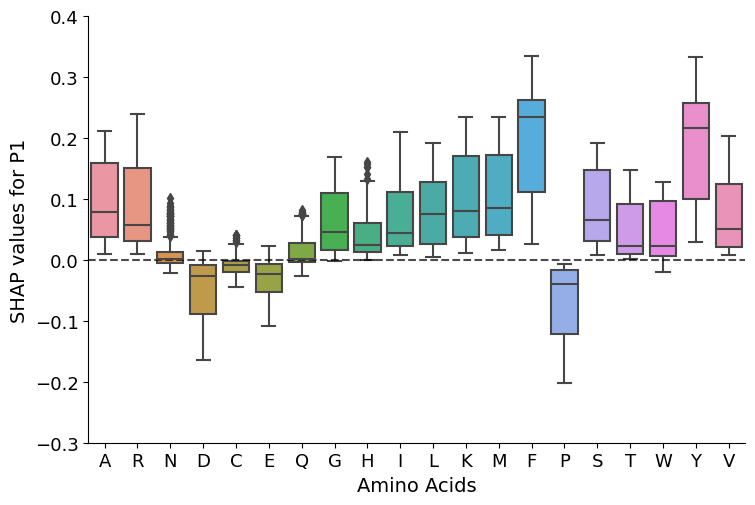

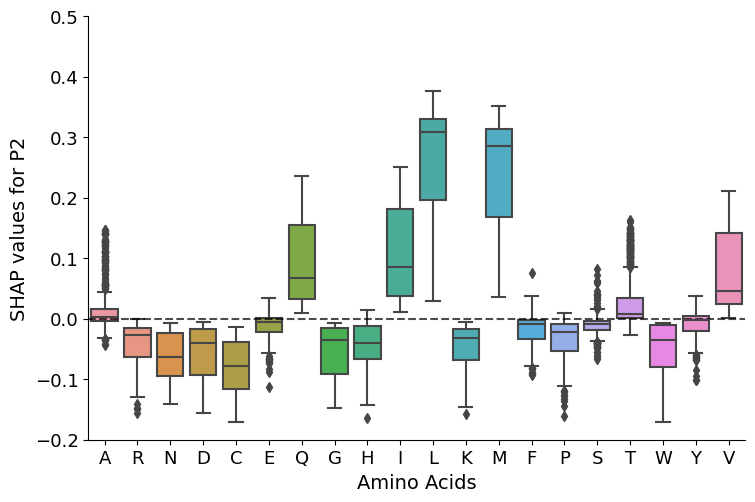

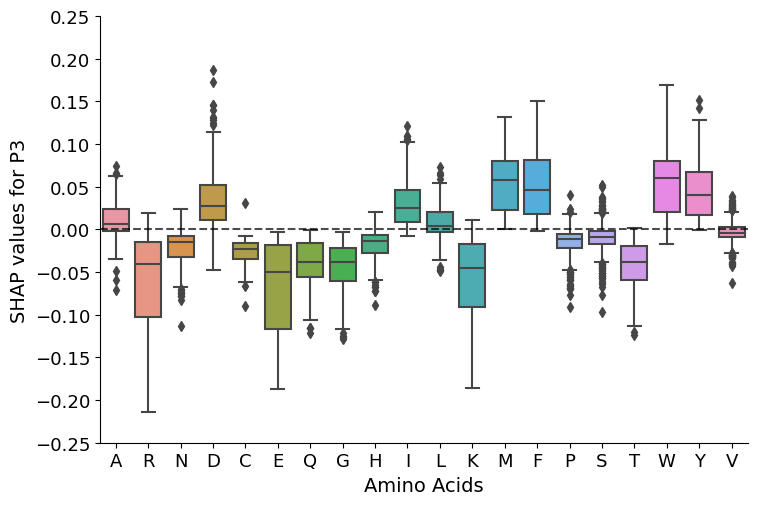

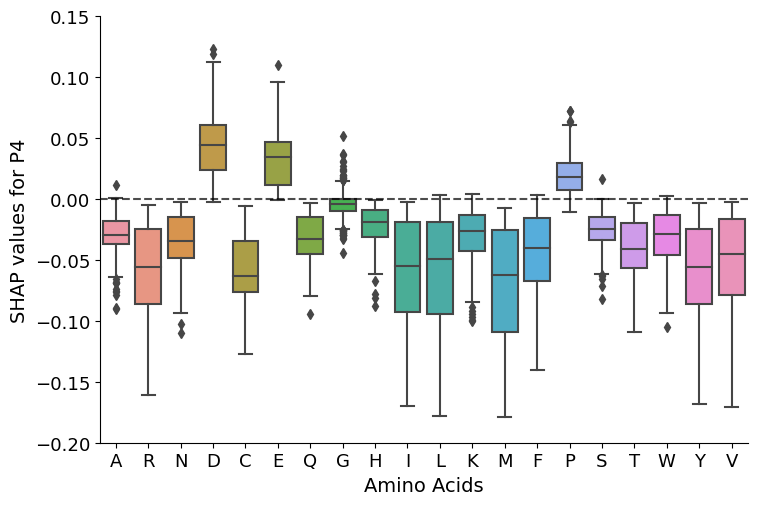

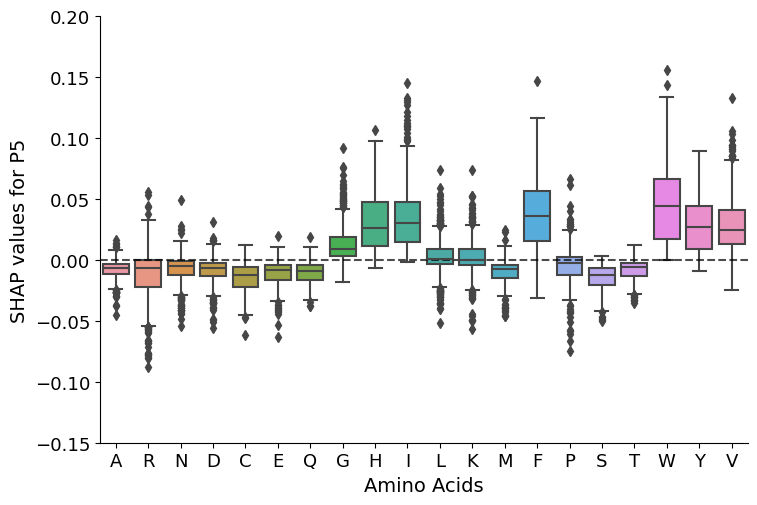

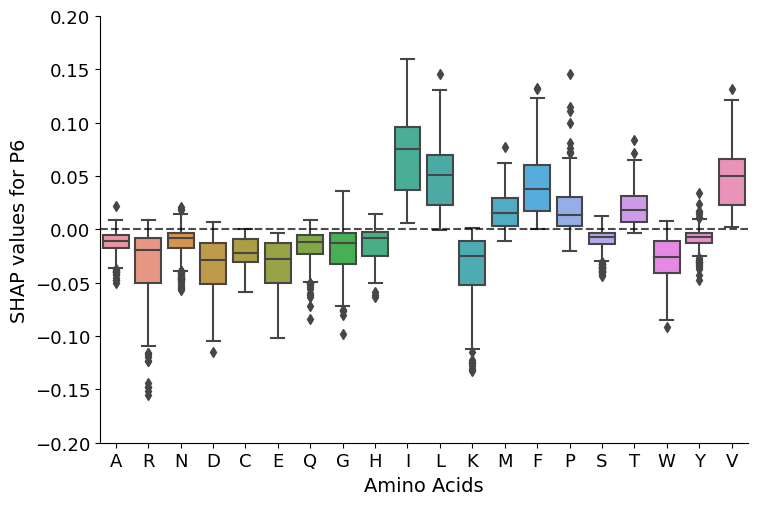

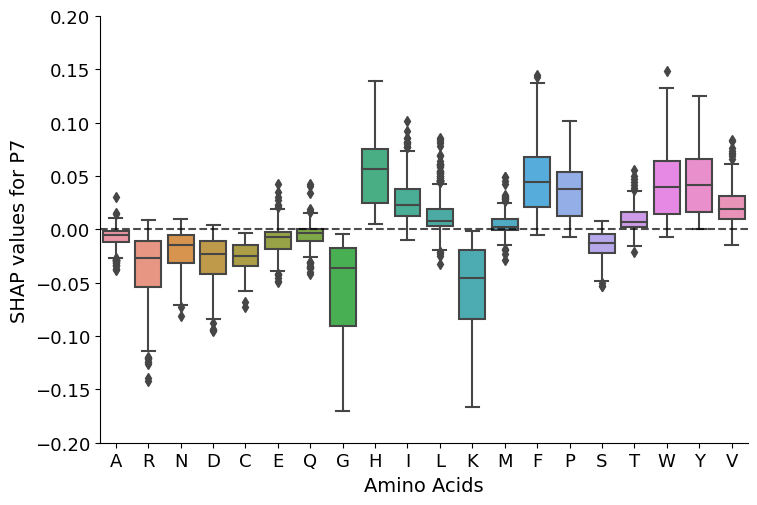

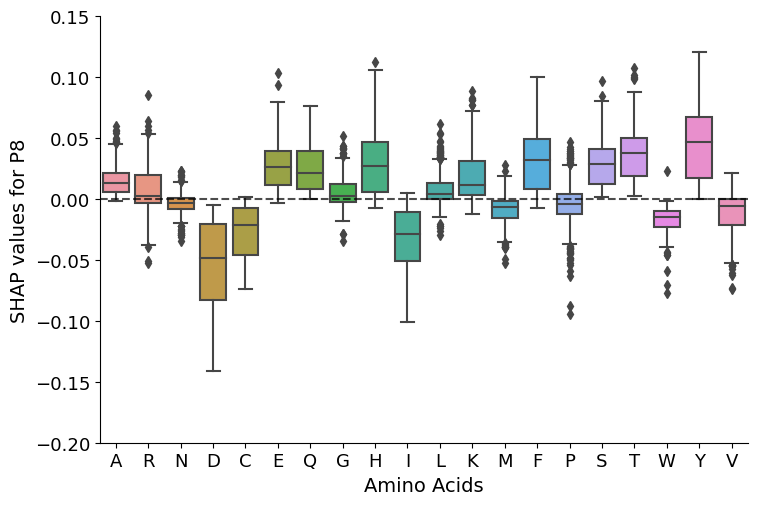

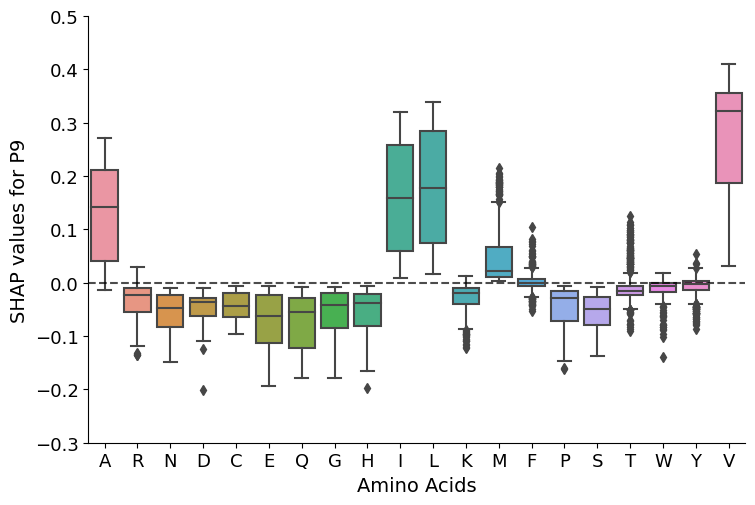

In [54]:
import matplotlib.ticker as ticker

aa_df = {1:{aa_:[] for aa_ in aa},
         2:{aa_:[] for aa_ in aa},
         3:{aa_:[] for aa_ in aa},
         4:{aa_:[] for aa_ in aa},
         5:{aa_:[] for aa_ in aa},
         6:{aa_:[] for aa_ in aa},
         7:{aa_:[] for aa_ in aa},
         8:{aa_:[] for aa_ in aa},
         9:{aa_:[] for aa_ in aa}}


for peptide in SHAP_A0201_df.index:
    values = SHAP_A0201_df.loc[peptide].to_numpy()
    for idx,i in enumerate(peptide):
        x = idx+1
        y = i
        aa_df[x][y] = aa_df[x][y] + [values[x-1]]      
        
lim_ = (-0.3,0.5)
for i in range(9):
    x = []
    y = []
    for k,v in aa_df[i+1].items():
        x = x + len(v)*[k]
        y = y + v

    df = pd.DataFrame({'aa':x,'shap':y})

    b = sns.catplot(x = 'aa', y = 'shap', 
                data=df,kind='box',aspect=1.5)
    b.set_xticklabels(size = 13)
    b.set_yticklabels(size = 13)
    b.axes[0][0].axhline( 0.0, color='black', alpha=.7, ls='--')
    b.set_ylabels('SHAP values for P'+str(i+1),size=14)
    b.set_xlabels('Amino Acids',size=14)
    plt.show()
